In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc, rcParams
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import h5py
from tqdm import tqdm
import plot_utils as pltu
from UNITS import *
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import json

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
pltu.plot_settings(rc, rcParams)

In [5]:
GW241011_data_file = 'GW241011_GW241110_data_release/data/ancestors/GW241011_ancestral_properties_forwards.json'

In [7]:
GW241011_post_file = 'GW241011_GW241110_data_release/data/standard_pe/GW241011_posterior_samples_combined.h5'

In [9]:
GW241011_dat = h5py.File(GW241011_post_file,'r')

In [11]:
GW241011_dat['C00:Mixed'].keys()

<KeysViewHDF5 ['meta_data', 'posterior_samples']>

In [13]:
def lousto_kick(q, s1x, s1y, s1z, s2x, s2y, s2z):
    """
    Vectorized Lousto & Zlochower (2011) recoil kick formula.
    All inputs are 1D numpy arrays of the same length.
    Returns magnitudes of kick velocity arrays (km/s).
    """

    # Constants (Lousto+2011)
    A = 1.2e4  # km/s
    B = -0.93
    H = 6.9e3
    K = 6.0e4
    xi = np.deg2rad(145)

    # Symmetric mass ratio
    eta = q / (1 + q)**2

    # Spin difference vector Delta = S2/m2 - S1/m1
    Dx = s2x - s1x/q
    Dy = s2y - s1y/q
    Dz = s2z - s1z/q

    # Components
    Delta_perp = np.sqrt(Dx**2 + Dy**2)   # magnitude
    Delta_par  = Dz

    # --- Basis vectors (simple fixed orthonormal basis) ---
    # e1 = (1,0,0); e2 = (0,1,0), ez = (0,0,1)

    # 1) Mass asymmetry term
    Vm = A * eta**2 * np.sqrt(1 - 4*eta) * (1 + B*eta)
    Vmx = Vm
    Vmy = np.zeros_like(Vm)
    Vmz = np.zeros_like(Vm)

    # 2) In-plane spin term
    Vp = H * eta**2 * Delta_par
    Vpx = Vp * np.cos(xi)
    Vpy = Vp * np.sin(xi)
    Vpz = np.zeros_like(Vp)

    # 3) Superkick term (out of plane)
    Vk = K * eta**2 * Delta_perp
    # phase (ignore phi dependencies; set cos term=1 for averaging)
    Vkz = Vk
    Vkx = np.zeros_like(Vk)
    Vky = np.zeros_like(Vk)

    # Total vector
    Vx = Vmx + Vpx + Vkx
    Vy = Vmy + Vpy + Vky
    Vz = Vmz + Vpz + Vkz

    return np.sqrt(Vx**2 + Vy**2 + Vz**2)

In [15]:
threeG_kick_GW241011 = lousto_kick(
    GW241011_dat['C00:Mixed']['posterior_samples']['mass_ratio'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1x'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1y'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1z'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2x'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2y'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2z']
) 

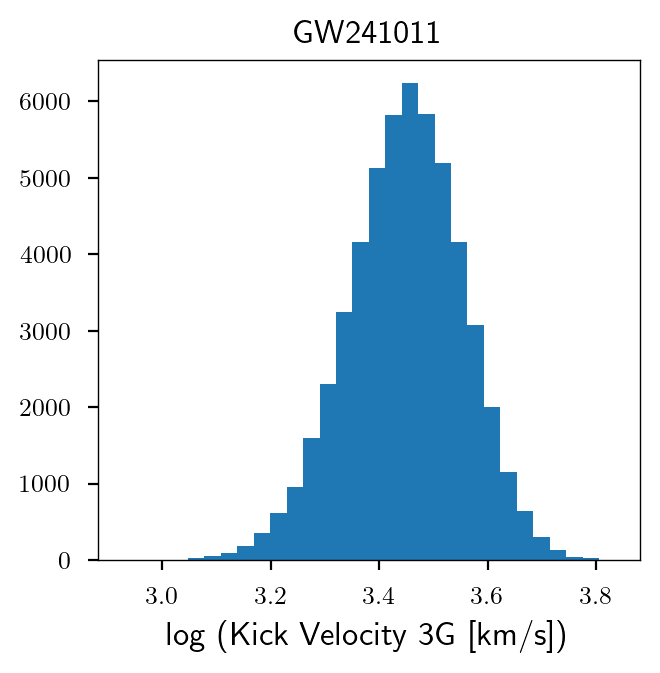

In [17]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(threeG_kick_GW241011), bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity 3G [km/s])')
plt.show()

In [19]:
f = open(GW241011_data_file)
data_GW241011 = json.load(f)
f.close()

In [21]:
data_GW241011['posterior']['content'].keys()

dict_keys(['mass_1_source', 'mass_ratio', 'a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'phi_12', 'log_likelihood', 'log_prior', 'chi_eff', 'chi_p', 'final_mass_source', 'final_spin', 'final_kick'])

In [23]:
vr_post_GW241011 = np.array(data_GW241011['posterior']['content']['final_kick'])

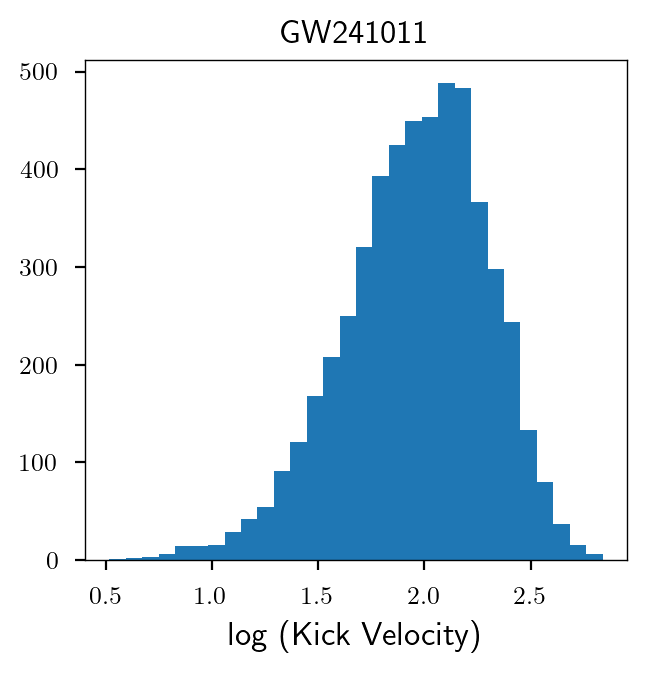

In [25]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241011), bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity)')
plt.show()

In [27]:
def get_v_esc(M0, a, r):
    psi = G * 10**M0 * M_sun / (a * PC) / np.sqrt(1 + (r / a)**2)
    return np.sqrt(2 * psi) / 1e3               # in km/s

In [29]:
def p_of_v(v, v_esc):
    x = v / v_esc
    p_v = 512 / 7 / np.pi / v_esc * x**2 * (1 - x**2)**7/2
    return p_v

In [31]:
def p_of_r(r, a):
    x = r / a
    return 3 * x**2 * (1 + x**2)**(-5/2) / a

In [33]:
def generate_samps_from_post(N, post):
    hist, bin_edges = np.histogram(post, bins=1000, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, bin_edges[1:])
    return samples

In [35]:
def generate_samps_from_dist(N, init_samp, pdf):
    init_samp_pdf = pdf(init_samp)
    cdf = integrate.cumulative_trapezoid(init_samp_pdf, init_samp, initial=0)
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, init_samp)
    return samples

In [69]:
np.random.seed(1234)

In [71]:
N = 100000

In [72]:
M0_samp = np.linspace(4, 10, 1000)            # M0 uniform in Log Space
a_samp = np.linspace(0.16, 1.5, 5)

In [73]:
r_samp = np.linspace(0, 5, 750)

In [75]:
ret_prob = np.zeros((len(M0_samp), len(r_samp)))

In [77]:
rej_prob = np.zeros((len(M0_samp), len(r_samp)))

## $a = 0.16\,\rm pc$

In [79]:
for ii in tqdm(range(len(M0_samp))):
    for jj in range(len(r_samp)):
        cos_theta_samp = np.random.uniform(-1, 1, N)
        vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
        vr_3G_samp_GW241011 = generate_samps_from_post(N, threeG_kick_GW241011)
        
        v_esc_samp = get_v_esc(M0_samp[ii], a_samp[0], r_samp[jj])
        v_init = np.linspace(0, v_esc_samp, 1000)
        v_dist_func = lambda x: p_of_v(x, v_esc_samp)
        v_samp = generate_samps_from_dist(N, v_init, v_dist_func)

        v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)
        v_true_ret_GW241011 = np.sqrt(v_samp**2 + vr_3G_samp_GW241011**2 + 2 * v_samp * vr_3G_samp_GW241011 * cos_theta_samp)
        
        ret_prob[ii][jj] = len(np.where(v_true_GW241011 < v_esc_samp)[0]) / N
        rej_prob[ii][jj] = len(np.where(v_true_ret_GW241011 >= v_esc_samp)[0]) / N

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:22:39<00:00, 12.16s/it]


In [87]:
X, Y = np.meshgrid(r_samp, M0_samp)

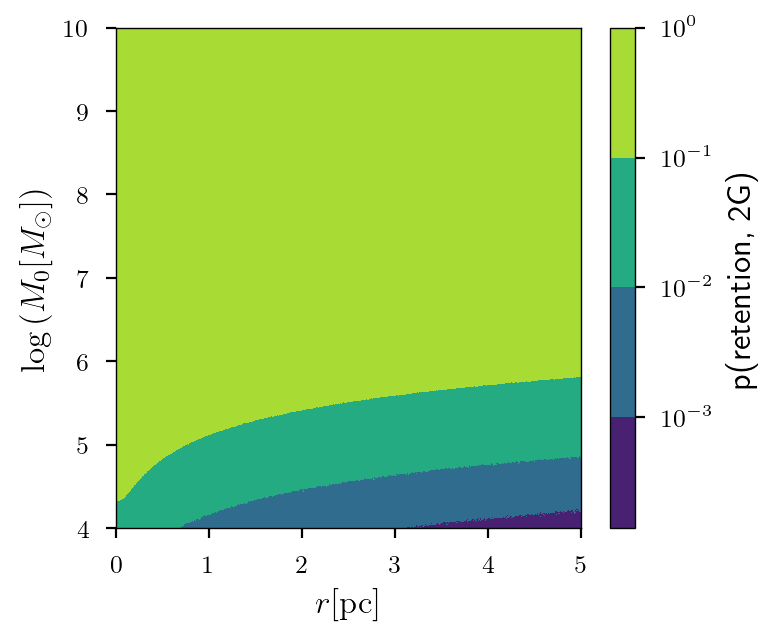

In [139]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, ret_prob, norm = colors.LogNorm(vmin = np.min(ret_prob), vmax = 1))
clb = plt.colorbar()
clb.ax.set_ylim(np.min(ret_prob), 1)
clb.ax.set_ylabel(r'p(retention, 2G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

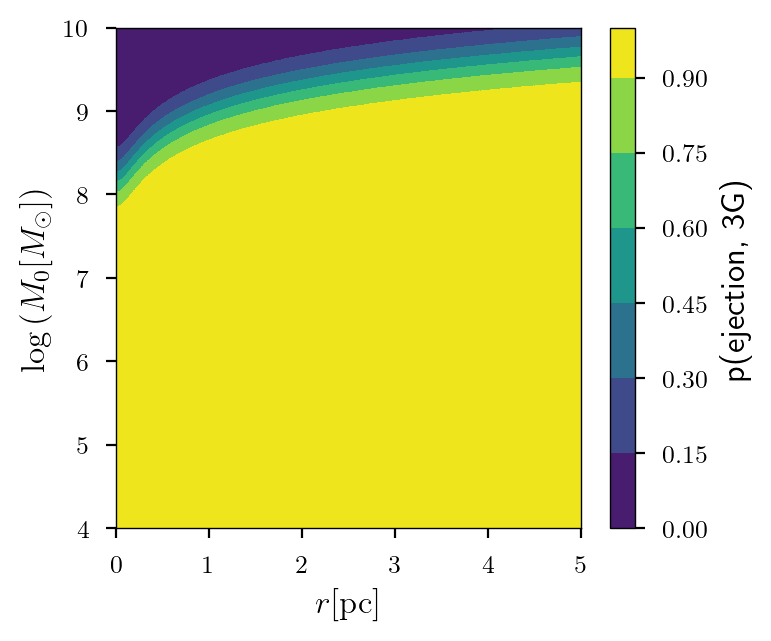

In [149]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, rej_prob, vmin = 0, vmax = 1)
clb = plt.colorbar()
clb.ax.set_ylim(0, 1)
clb.ax.set_ylabel(r'p(ejection, 3G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

## $a = 0.495\,\rm pc$

In [155]:
ret_prob_a2 = np.zeros((len(M0_samp), len(r_samp)))
rej_prob_a2 = np.zeros((len(M0_samp), len(r_samp)))

In [157]:
a_samp[1]

0.495

In [160]:
for ii in tqdm(range(len(M0_samp))):
    for jj in range(len(r_samp)):
        cos_theta_samp = np.random.uniform(-1, 1, N)
        vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
        vr_3G_samp_GW241011 = generate_samps_from_post(N, threeG_kick_GW241011)
        
        v_esc_samp = get_v_esc(M0_samp[ii], a_samp[1], r_samp[jj])
        v_init = np.linspace(0, v_esc_samp, 1000)
        v_dist_func = lambda x: p_of_v(x, v_esc_samp)
        v_samp = generate_samps_from_dist(N, v_init, v_dist_func)

        v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)
        v_true_ret_GW241011 = np.sqrt(v_samp**2 + vr_3G_samp_GW241011**2 + 2 * v_samp * vr_3G_samp_GW241011 * cos_theta_samp)
        
        ret_prob_a2[ii][jj] = len(np.where(v_true_GW241011 < v_esc_samp)[0]) / N
        rej_prob_a2[ii][jj] = len(np.where(v_true_ret_GW241011 >= v_esc_samp)[0]) / N

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:23:31<00:00, 12.21s/it]


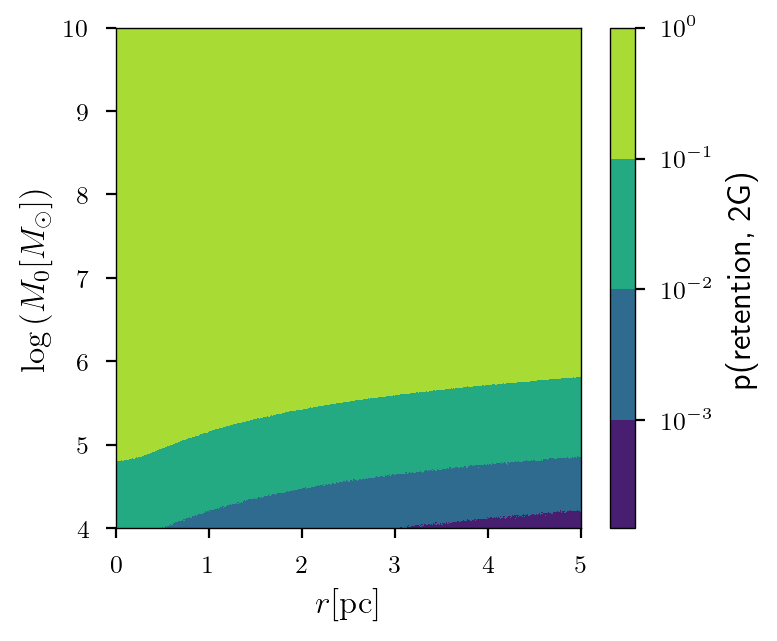

In [161]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, ret_prob_a2, norm = colors.LogNorm(vmin = np.min(ret_prob_a2), vmax = 1))
clb = plt.colorbar()
clb.ax.set_ylim(np.min(ret_prob_a2), 1)
clb.ax.set_ylabel(r'p(retention, 2G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

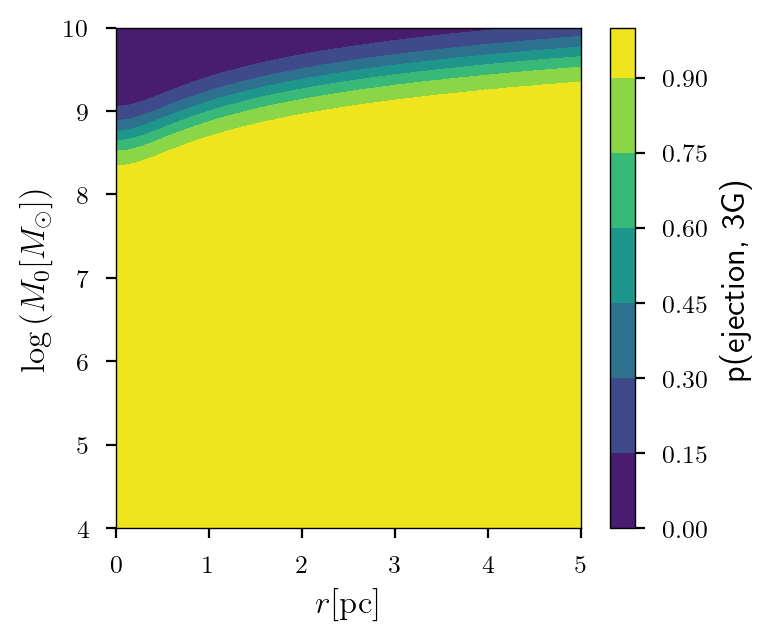

In [162]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, rej_prob_a2, vmin = 0, vmax = 1)
clb = plt.colorbar()
clb.ax.set_ylim(0, 1)
clb.ax.set_ylabel(r'p(ejection, 3G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

## $a = 0.83\,\rm pc$

In [180]:
ret_prob_a3 = np.zeros((len(M0_samp), len(r_samp)))
rej_prob_a3 = np.zeros((len(M0_samp), len(r_samp)))

In [182]:
for ii in tqdm(range(len(M0_samp))):
    for jj in range(len(r_samp)):
        cos_theta_samp = np.random.uniform(-1, 1, N)
        vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
        vr_3G_samp_GW241011 = generate_samps_from_post(N, threeG_kick_GW241011)
        
        v_esc_samp = get_v_esc(M0_samp[ii], a_samp[2], r_samp[jj])
        v_init = np.linspace(0, v_esc_samp, 1000)
        v_dist_func = lambda x: p_of_v(x, v_esc_samp)
        v_samp = generate_samps_from_dist(N, v_init, v_dist_func)

        v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)
        v_true_ret_GW241011 = np.sqrt(v_samp**2 + vr_3G_samp_GW241011**2 + 2 * v_samp * vr_3G_samp_GW241011 * cos_theta_samp)
        
        ret_prob_a3[ii][jj] = len(np.where(v_true_GW241011 < v_esc_samp)[0]) / N
        rej_prob_a3[ii][jj] = len(np.where(v_true_ret_GW241011 >= v_esc_samp)[0]) / N

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:23:09<00:00, 12.19s/it]


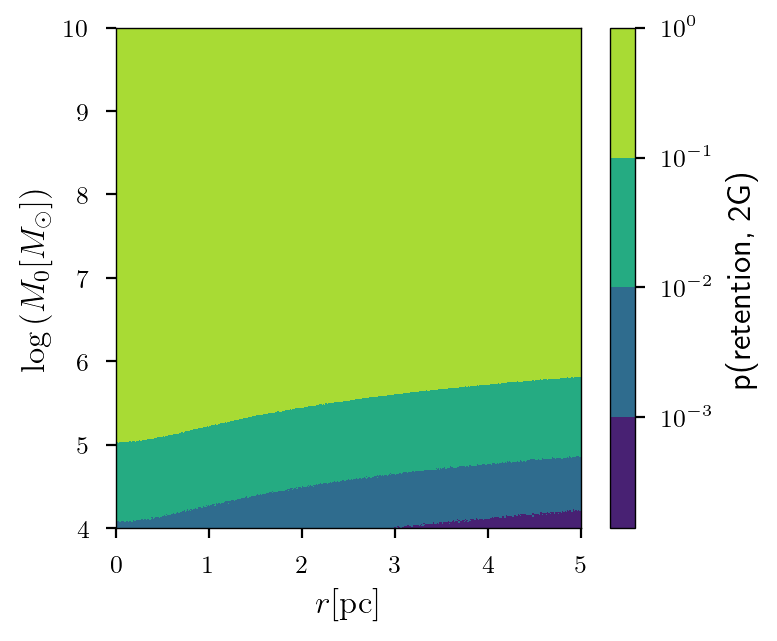

In [183]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, ret_prob_a3, norm = colors.LogNorm(vmin = np.min(ret_prob_a3), vmax = 1))
clb = plt.colorbar()
clb.ax.set_ylim(np.min(ret_prob_a3), 1)
clb.ax.set_ylabel(r'p(retention, 2G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

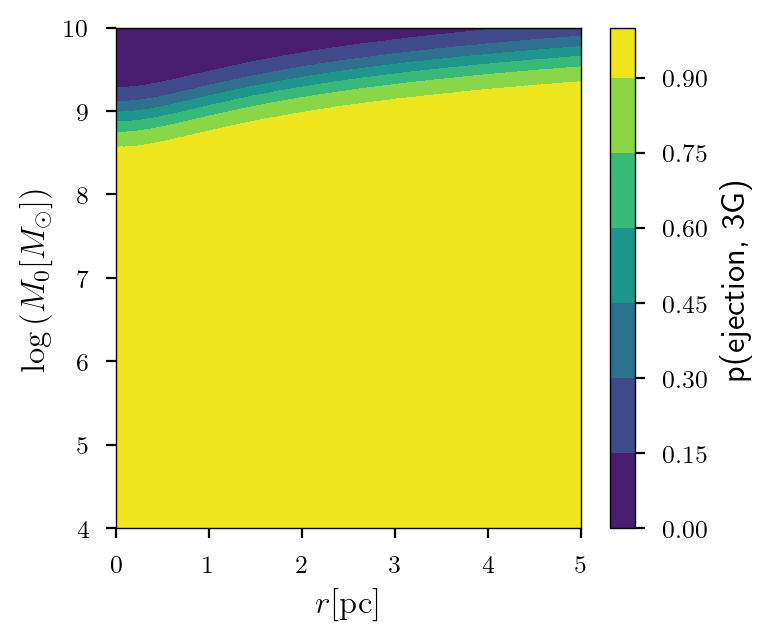

In [184]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, rej_prob_a3, vmin = 0, vmax = 1)
clb = plt.colorbar()
clb.ax.set_ylim(0, 1)
clb.ax.set_ylabel(r'p(ejection, 3G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

## $a = 0.1.165\,\rm pc$

In [185]:
ret_prob_a4 = np.zeros((len(M0_samp), len(r_samp)))
rej_prob_a4 = np.zeros((len(M0_samp), len(r_samp)))

In [186]:
for ii in tqdm(range(len(M0_samp))):
    for jj in range(len(r_samp)):
        cos_theta_samp = np.random.uniform(-1, 1, N)
        vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
        vr_3G_samp_GW241011 = generate_samps_from_post(N, threeG_kick_GW241011)
        
        v_esc_samp = get_v_esc(M0_samp[ii], a_samp[3], r_samp[jj])
        v_init = np.linspace(0, v_esc_samp, 1000)
        v_dist_func = lambda x: p_of_v(x, v_esc_samp)
        v_samp = generate_samps_from_dist(N, v_init, v_dist_func)

        v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)
        v_true_ret_GW241011 = np.sqrt(v_samp**2 + vr_3G_samp_GW241011**2 + 2 * v_samp * vr_3G_samp_GW241011 * cos_theta_samp)
        
        ret_prob_a4[ii][jj] = len(np.where(v_true_GW241011 < v_esc_samp)[0]) / N
        rej_prob_a4[ii][jj] = len(np.where(v_true_ret_GW241011 >= v_esc_samp)[0]) / N

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:22:57<00:00, 12.18s/it]


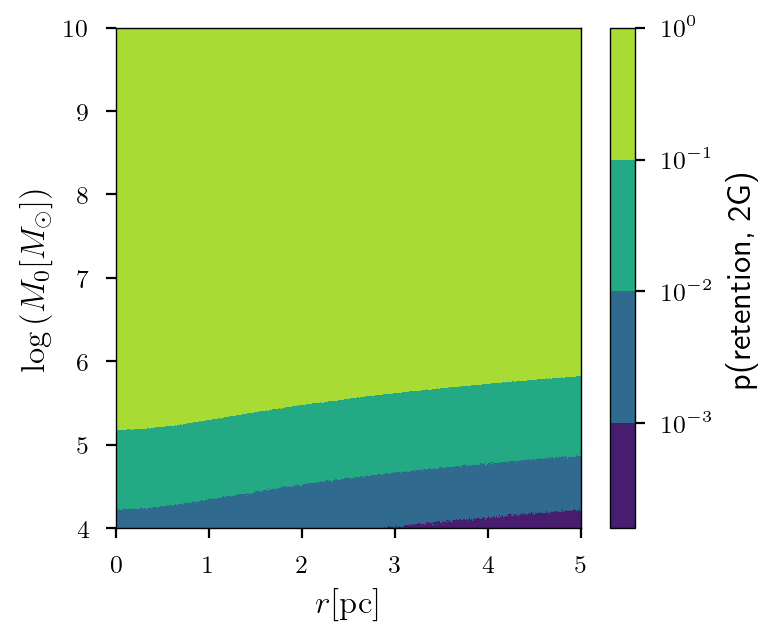

In [187]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, ret_prob_a4, norm = colors.LogNorm(vmin = np.min(ret_prob_a4), vmax = 1))
clb = plt.colorbar()
clb.ax.set_ylim(np.min(ret_prob_a4), 1)
clb.ax.set_ylabel(r'p(retention, 2G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

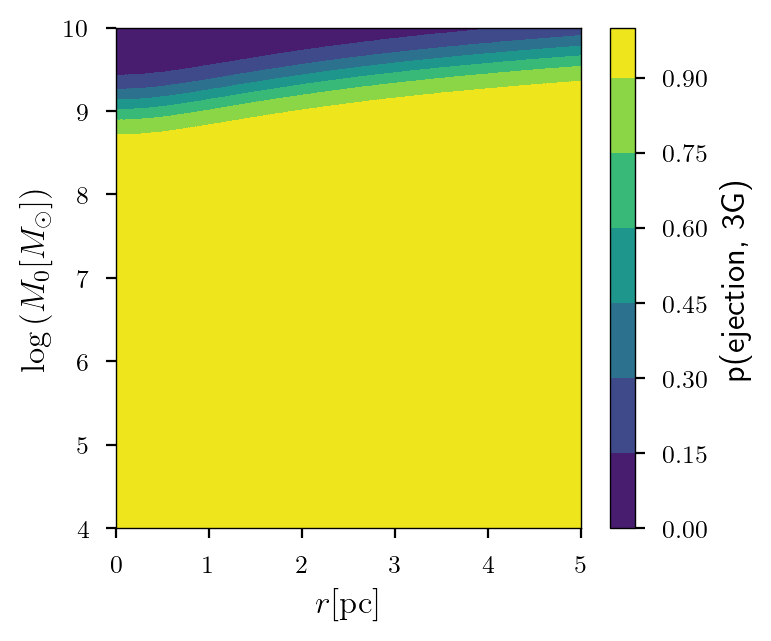

In [188]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, rej_prob_a4, vmin = 0, vmax = 1)
clb = plt.colorbar()
clb.ax.set_ylim(0, 1)
clb.ax.set_ylabel(r'p(ejection, 3G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

## $a = 1.5\,\rm pc$

In [190]:
ret_prob_a5 = np.zeros((len(M0_samp), len(r_samp)))
rej_prob_a5 = np.zeros((len(M0_samp), len(r_samp)))

In [191]:
for ii in tqdm(range(len(M0_samp))):
    for jj in range(len(r_samp)):
        cos_theta_samp = np.random.uniform(-1, 1, N)
        vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
        vr_3G_samp_GW241011 = generate_samps_from_post(N, threeG_kick_GW241011)
        
        v_esc_samp = get_v_esc(M0_samp[ii], a_samp[4], r_samp[jj])
        v_init = np.linspace(0, v_esc_samp, 1000)
        v_dist_func = lambda x: p_of_v(x, v_esc_samp)
        v_samp = generate_samps_from_dist(N, v_init, v_dist_func)

        v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)
        v_true_ret_GW241011 = np.sqrt(v_samp**2 + vr_3G_samp_GW241011**2 + 2 * v_samp * vr_3G_samp_GW241011 * cos_theta_samp)
        
        ret_prob_a5[ii][jj] = len(np.where(v_true_GW241011 < v_esc_samp)[0]) / N
        rej_prob_a5[ii][jj] = len(np.where(v_true_ret_GW241011 >= v_esc_samp)[0]) / N

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:23:16<00:00, 12.20s/it]


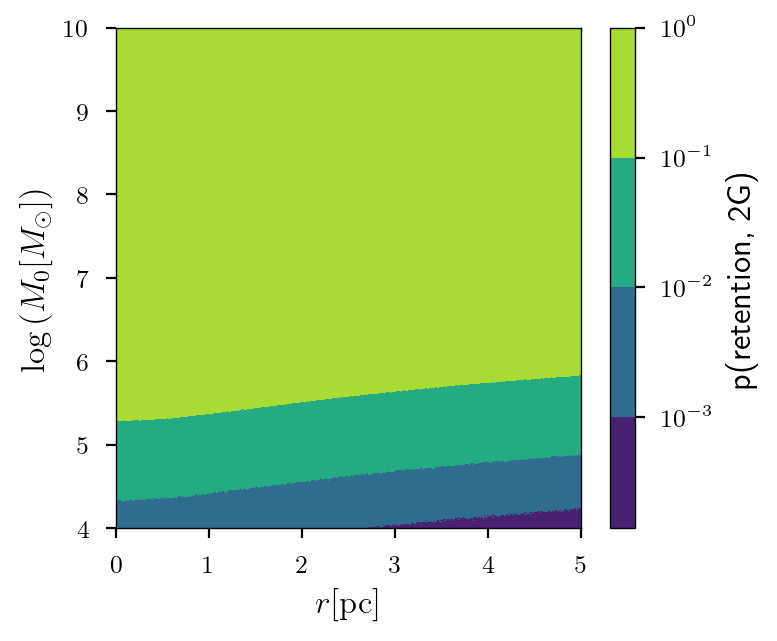

In [192]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, ret_prob_a5, norm = colors.LogNorm(vmin = np.min(ret_prob_a5), vmax = 1))
clb = plt.colorbar()
clb.ax.set_ylim(np.min(ret_prob_a5), 1)
clb.ax.set_ylabel(r'p(retention, 2G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()

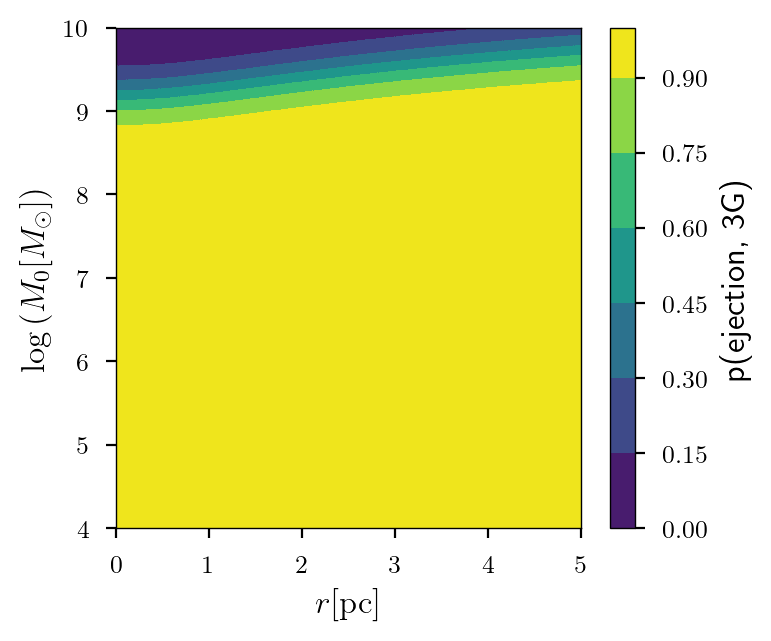

In [193]:
plt.figure(frameon=False, figsize=(3.75, 3.25), dpi=200)

plt.contourf(X, Y, rej_prob_a5, vmin = 0, vmax = 1)
clb = plt.colorbar()
clb.ax.set_ylim(0, 1)
clb.ax.set_ylabel(r'p(ejection, 3G)')

plt.xlabel(r'$r[\rm pc]$')
plt.ylabel(r'$\log \left( M_0[M_{\odot}] \right)$')

#plt.xscale('log')
#plt.xlim(0, 5)

plt.show()